In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [2]:
# Load the dataset
file_path = 'concepts_counts_data.csv'
data = pd.read_csv(file_path)

In [3]:
# Reshape data from wide to long format
data_long = pd.melt(data, id_vars=['Concept', 'ID'], value_vars=[str(year) for year in range(2013, 2024)],
                    var_name='Year', value_name='Count')
data_long['Year'] = pd.to_datetime(data_long['Year'], format='%Y')

In [4]:
year_columns = [str(year) for year in range(2013, 2024)]
data[year_columns] = data[year_columns].astype(float)

In [5]:
cumsum_data = data.loc[:, year_columns].cumsum(axis=1)
cumsum_data

,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,60.0,98.0,132.0,153.0,171.0,185.0,207.0,234.0,246.0,262.0,266.0
1,87.0,179.0,266.0,365.0,455.0,561.0,648.0,747.0,859.0,995.0,1114.0
2,65705.0,130268.0,196461.0,260811.0,326360.0,396991.0,470565.0,554560.0,641444.0,718527.0,796822.0
3,170.0,299.0,469.0,607.0,741.0,871.0,984.0,1097.0,1189.0,1266.0,1357.0
4,13.0,40.0,56.0,68.0,92.0,114.0,125.0,137.0,155.0,168.0,182.0
...,...,...,...,...,...,...,...,...,...,...,...
995,255812.0,519434.0,808324.0,1078060.0,1354085.0,1634085.0,1923268.0,2260362.0,2531767.0,2772336.0,3018586.0
996,2585.0,4775.0,6679.0,8262.0,9474.0,10709.0,11785.0,12835.0,13793.0,14573.0,15294.0
997,54651.0,111096.0,167741.0,232123.0,290234.0,350672.0,410761.0,477412.0,538750.0,610378.0,662259.0
998,1302.0,2603.0,3961.0,5305.0,6644.0,8220.0,9827.0,11587.0,13453.0,15342.0,17252.0


In [ ]:
# Processing each concept
results = []
for concept in tqdm(data_long['Concept'].unique(), desc="Processing Concepts"):
    # Isolate data for the current concept
    concept_data = data_long[data_long['Concept'] == concept]
    concept_id_full = concept_data['ID'].iloc[0]
    concept_id = concept_id_full.split('/')[-1]

    # Create a time series of cumulative counts
    ts_data = concept_data.set_index('Year')['Count']
    cumulative_ts_data = ts_data.cumsum()

    # Fit the ARIMA model on cumulative data (excluding 2023 for training)
    model = ARIMA(cumulative_ts_data[:-1], order=(1,0,1))
    fitted_model = model.fit()

    # Forecast the cumulative value for 2023
    forecast = fitted_model.forecast(steps=1)

    # Retrieve actual cumulative value for 2023
    actual_cumulative_2023 = cumulative_ts_data['2023-01-01']

    # Calculate errors
    absolute_error = abs(forecast[0] - actual_cumulative_2023)
    percentage_error = (absolute_error / actual_cumulative_2023) * 100

    # Store results
    results.append({
        'Concept': concept,
        'ID': concept_id,
        'Forecasted Cumulative Count 2023': forecast[0],
        'Actual Cumulative Count 2023': actual_cumulative_2023,
        'Absolute Error': absolute_error,
        'Percentage Error': percentage_error
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv('node_forecast_results.csv', index=False)

results_df

Processing Concepts: 100%|██████████| 1000/1000 [02:45<00:00,  6.05it/s]


,Concept,ID,Forecasted Cumulative Count 2023,Actual Cumulative Count 2023,Absolute Error,Percentage Error
0,.NET Framework,C523747234,2.736934e+02,266,7.693403,2.892257
1,Abductive reasoning,C166088908,1.069447e+03,1114,44.553337,3.999402
2,Abstract data type,C177264268,7.378687e+05,796822,58953.289288,7.398552
3,Abstract interpretation,C2780654840,1.296525e+03,1357,60.475302,4.456544
4,Abstract machine,C88977235,1.701996e+02,182,11.800447,6.483762
...,...,...,...,...,...,...
995,World Wide Web,C136764020,2.843529e+06,3018586,175056.787103,5.799298
996,XML,C8797682,1.496399e+04,15294,330.008754,2.157766
997,Zoology,C90856448,6.374725e+05,662259,24786.484637,3.742718
998,k-nearest neighbors algorithm,C113238511,1.621658e+04,17252,1035.423786,6.001761


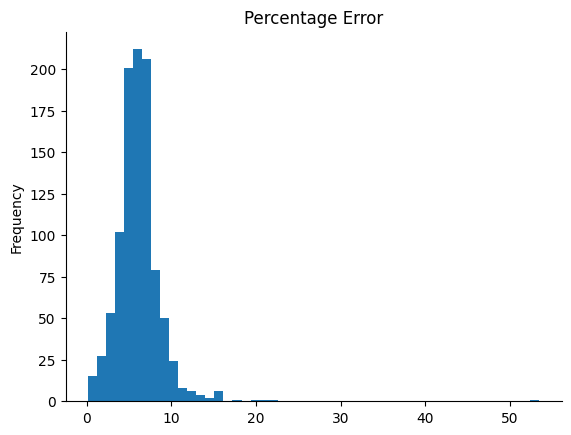

In [ ]:
# @title Percentage Error

from matplotlib import pyplot as plt
results_df['Percentage Error'].plot(kind='hist', bins=50, title='Percentage Error')
plt.gca().spines[['top', 'right',]].set_visible(False)

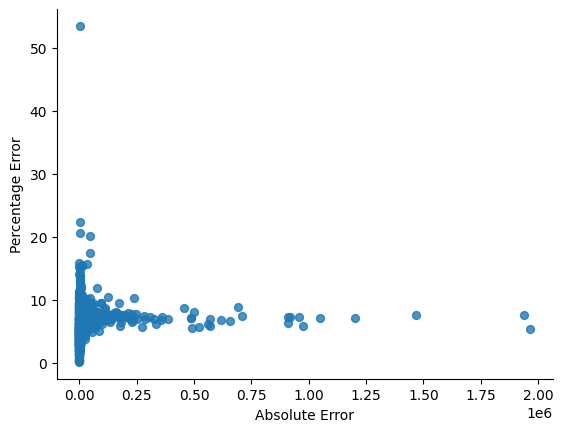

In [ ]:
# @title Absolute Error vs Percentage Error

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='Absolute Error', y='Percentage Error', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Calculate the mean percentage error
mean_percentage_error = results_df['Percentage Error'].mean()

# Print the mean percentage error
print(f"Mean Percentage Error: {mean_percentage_error:.2f}%")

Mean Percentage Error: 6.19%


### Graph Preprocessing

In [ ]:
forecasted_paper_count = results_df['Forecasted Cumulative Count 2023'] - cumsum_data['2022']
forecasted_paper_count_df = pd.DataFrame({
    'Concept': results_df['Concept'],
    'ID': results_df['ID'],
    'Paper Count': forecasted_paper_count
})
forecasted_paper_count_df


,Concept,ID,Paper Count
0,.NET Framework,C523747234,11.693403
1,Abductive reasoning,C166088908,74.446663
2,Abstract data type,C177264268,19341.710712
3,Abstract interpretation,C2780654840,30.524698
4,Abstract machine,C88977235,2.199553
...,...,...,...
995,World Wide Web,C136764020,71193.212897
996,XML,C8797682,390.991246
997,Zoology,C90856448,27094.515363
998,k-nearest neighbors algorithm,C113238511,874.576214


In [ ]:
forecasted_paper_count_df.to_csv('graph_node_data.csv')

### 2024 Prediction

In [6]:
# Processing each concept
results = []
for concept in tqdm(data_long['Concept'].unique(), desc="Processing Concepts"):
    # Isolate data for the current concept
    concept_data = data_long[data_long['Concept'] == concept]
    concept_id_full = concept_data['ID'].iloc[0]
    concept_id = concept_id_full.split('/')[-1]

    # Create a time series of cumulative counts
    ts_data = concept_data.set_index('Year')['Count']
    cumulative_ts_data = ts_data.cumsum()

    # Fit the ARIMA model on cumulative data (excluding 2023 for training)
    model = ARIMA(cumulative_ts_data, order=(1,0,1))
    fitted_model = model.fit()

    # Forecast the cumulative value for 2023
    forecast = fitted_model.forecast(steps=1)


    # Store results
    results.append({
        'Concept': concept,
        'ID': concept_id,
        'Forecasted Cumulative Count 2023': forecast[0],
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv('node_forecast_results.csv', index=False)

results_df

Processing Concepts: 100%|██████████| 1000/1000 [01:21<00:00, 12.29it/s]


,Concept,ID,Forecasted Cumulative Count 2023
0,.NET Framework,C523747234,2.552412e+02
1,Abductive reasoning,C166088908,1.134396e+03
2,Abstract data type,C177264268,8.200691e+05
3,Abstract interpretation,C2780654840,1.396678e+03
4,Abstract machine,C88977235,1.900824e+02
...,...,...,...
995,World Wide Web,C136764020,3.071726e+06
996,XML,C8797682,1.544630e+04
997,Zoology,C90856448,6.629081e+05
998,k-nearest neighbors algorithm,C113238511,1.797875e+04


In [8]:
forecasted_paper_count = abs(results_df['Forecasted Cumulative Count 2023'] - cumsum_data['2023'])
forecasted_paper_count_df = pd.DataFrame({
    'Concept': results_df['Concept'],
    'ID': results_df['ID'],
    'Paper Count': forecasted_paper_count
})
forecasted_paper_count_df

,Concept,ID,Paper Count
0,.NET Framework,C523747234,10.758823
1,Abductive reasoning,C166088908,20.396323
2,Abstract data type,C177264268,23247.118371
3,Abstract interpretation,C2780654840,39.677772
4,Abstract machine,C88977235,8.082365
...,...,...,...
995,World Wide Web,C136764020,53140.144560
996,XML,C8797682,152.304547
997,Zoology,C90856448,649.099149
998,k-nearest neighbors algorithm,C113238511,726.753667


In [9]:
forecasted_paper_count_df.to_csv('node_forecast_results_2024.csv')